In [1]:
import tensorflow as tf

In [2]:
# Verificar si hay dispositivos GPU disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPUs disponibles:", gpus)
else:
    print("No se encontraron dispositivos GPU disponibles.")

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
from tensorflow.keras.applications import VGG19, MobileNetV2
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from PIL import Image

from tensorflow.keras.preprocessing import image
import foolbox as fb
import matplotlib.pyplot as plt
import os

In [4]:
# Cargar el modelo VGG16 preentrenado
model = VGG19(weights='imagenet')

In [5]:
# Cargar y preprocesar la imagen
img_path = os.path.join('data', 'Tiger_shark.jpg')
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

In [6]:
# Preparar el preprocesamiento para el modelo Foolbox, convertir mean y std a tensores
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])
preprocessing = {'mean': mean, 'std': std}

# Convertir el modelo de Keras a un modelo compatible con Foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0, 1), preprocessing=None)

# Aplicar manualmente el preprocesamiento usando TensorFlow para evitar problemas de compatibilidad
x = (tf.convert_to_tensor(x) - mean) / std

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


1/1 [==============================] - 0s 19ms/step


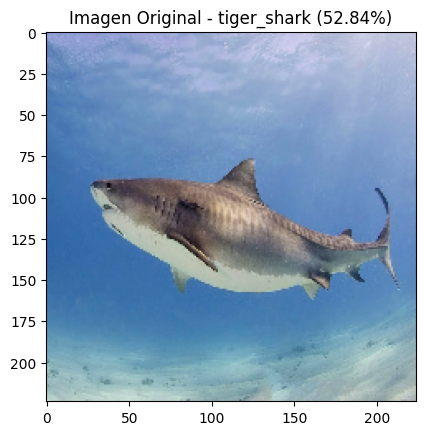

In [29]:
# Mostrar la imagen original (antes del preprocesamiento)

predsx = model.predict(x * 255.0)	
label = decode_predictions(predsx, top=1)[0][0]


plt.imshow(img)
plt.title("Imagen Original - {}".format(label[1]) + " ({:.2f}%)".format(label[2]*100))
plt.show()

In [8]:
# Definir el tamaño y la posición del parche
patch_size = 50
patch = np.random.rand(patch_size, patch_size, 3)  # Parche inicial aleatorio
patch_center = (112, 112)  # Centro del parche

# Optimizar el parche adversario
learning_rate = 0.2
iterations = 100
target_label = 7  # Etiqueta objetivo (por ejemplo, "cock" en ImageNet)


In [9]:
# Función para aplicar el parche a la imagen
def apply_patch(image, patch, center):
    patch_shape = tf.shape(patch)
    start_x = center[0] - patch_shape[0] // 2
    start_y = center[1] - patch_shape[1] // 2

    # Create a mask to insert the patch
    mask = tf.zeros_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=[[0, start_x + i, start_y + j, k] for i in range(patch_shape[0]) for j in range(patch_shape[1]) for k in range(patch_shape[2])],
        updates=tf.reshape(patch, [-1])
    )

    patched_image = image * (1 - mask) + mask
    return patched_image

In [10]:
# Convertir el parche a un tensor y asegurarse de que el tipo de datos es float32
patch = np.random.rand(patch_size, patch_size, 3).astype(np.float32)
patch = tf.Variable(patch, dtype=tf.float32)

# Optimizar el parche
optimizer = tf.optimizers.Adam(learning_rate)

In [11]:
for i in range(iterations):
    with tf.GradientTape() as tape:
        tape.watch(patch)
        # Aplicar el parche a la imagen de entrada
        patched_image = apply_patch(x, patch, patch_center)
        # Realizar una predicción con el modelo de la imagen parcheada
        preds = fmodel(patched_image)
        # Calcular la pérdida de entropía cruzada
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=[target_label], logits=preds)
    
    # Calcular los gradientes del parche con respecto a la pérdida
    grads = tape.gradient(loss, patch)
    if grads is not None:
        # Aplicar los gradientes al parche usando el optimizador
        optimizer.apply_gradients([(grads, patch)])
    else:
        print('No se encontraron gradientes.')
    
    # Clip del parche para mantenerlo en el rango válido
    patch.assign(tf.clip_by_value(patch, -3, 3))  # Ajusta según el rango de tu imagen preprocesada
    
    print(f'Iteración {i}, Pérdida: {np.mean(loss.numpy())}')


Iteración 0, Pérdida: 6.908535480499268
Iteración 1, Pérdida: 6.908501625061035
Iteración 2, Pérdida: 6.908471584320068
Iteración 3, Pérdida: 6.908446788787842
Iteración 4, Pérdida: 6.908426761627197
Iteración 5, Pérdida: 6.908403396606445
Iteración 6, Pérdida: 6.9083685874938965
Iteración 7, Pérdida: 6.908315658569336
Iteración 8, Pérdida: 6.908274173736572
Iteración 9, Pérdida: 6.908233642578125
Iteración 10, Pérdida: 6.908183574676514
Iteración 11, Pérdida: 6.908133506774902
Iteración 12, Pérdida: 6.908069133758545
Iteración 13, Pérdida: 6.907993316650391
Iteración 14, Pérdida: 6.907910346984863
Iteración 15, Pérdida: 6.907821178436279
Iteración 16, Pérdida: 6.907711982727051
Iteración 17, Pérdida: 6.907578468322754
Iteración 18, Pérdida: 6.90742826461792
Iteración 19, Pérdida: 6.907234191894531
Iteración 20, Pérdida: 6.907007694244385
Iteración 21, Pérdida: 6.906733989715576
Iteración 22, Pérdida: 6.906369209289551
Iteración 23, Pérdida: 6.9059157371521
Iteración 24, Pérdida: 6.905

In [12]:
# Aplicar el parche optimizado a la imagen
adversarial_image = apply_patch(x, patch, patch_center)

# Revertir el preprocesamiento para la visualización
adversarial_image_display = (adversarial_image[0] * preprocessing['std'] + preprocessing['mean']) * 255
adversarial_image_display = np.clip(adversarial_image_display, 0, 255).astype(np.uint8)

# adversarial_array = adversarial_image.numpy()
# img_adversaria = Image.fromarray(((adversarial_array[0] + 1) * 127.5).astype("uint8"))

1/1 [==============================] - 0s 18ms/step


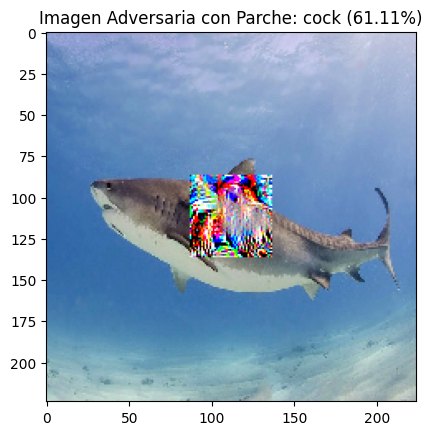

In [20]:
# Mostrar la imagen adversaria
# Predecir con la imagen adversaria utilizando el modelo original
preds = model.predict(adversarial_image)
prediction = decode_predictions(preds, top=1)[0][0][1] + " (" + str(round(decode_predictions(preds, top=1)[0][0][2]*100,2)) + "%)"

plt.imshow(adversarial_image_display)
plt.title("Imagen Adversaria con Parche: " + prediction)
plt.show()

In [ ]:
# Predecir con la imagen adversaria utilizando el modelo original
preds = model.predict(adversarial_image)
print('Predicción adversaria:', decode_predictions(preds, top=1)[0])

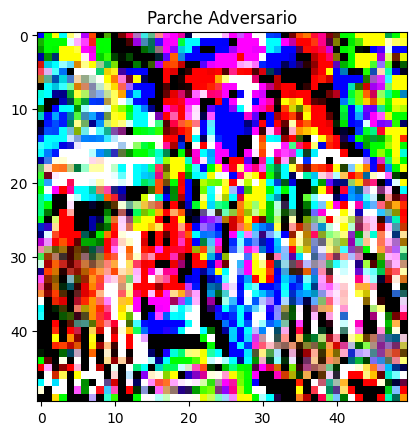

In [14]:

# Mostrar el parche adversario
patch_display = (patch.numpy() * preprocessing['std'] + preprocessing['mean']) * 255
patch_display = np.clip(patch_display, 0, 255).astype(np.uint8)
plt.imshow(patch_display)
plt.title("Parche Adversario")
plt.show()